In [1]:
#Notch and LOCoR for PLATO LCs: let's first consider individual quarters
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import core

lightcurves=pd.read_csv('../plato_brightbinned_example.csv')
time=np.array(lightcurves['time'])
flux=np.array(lightcurves['flux_w_transit'])

Prot = 3.12


# setting up the data in the format required by N&L


dl = len(time)
data         = np.recarray((dl,),dtype=[('t',float),('fraw',float),('fcor',float),('s',float),('qual',int),('divisions',float)])
data.t = time
data.fcor=flux # / np.nanmedian(outdata.fcor)

data.fraw[:]    = 0
data.s[:]      = 0
data.qual[:]    = 0

# These parameters shouldn't be changed
arclength=False
use_raw=False
deltabic = -1.0
transmask=[-1,-1]
alias_num=0.01
raw = False
resolvabletrans = False
show_progress = True
# demode==1: NOTCH
# demode==2: LOCoR


In [2]:
#Running Notch:
if(Prot>=13):
    wsize = 2.0
    fittimes, depth, detrend,polyshape,badflag = core.sliding_window(data,windowsize=wsize,use_arclength=arclength,use_raw=raw,deltabic=deltabic,resolvable_trans=resolvabletrans,cleanmask=transmask,show_progress=show_progress) ##Notch Filter
if(Prot>2 and Prot<13): #K2 lcs have a Prot between 0.1-13 days; PLATO lcs have Prot between 1-107 days!!!
    wsize = 1.0
    fittimes, depth, detrend,polyshape,badflag = core.sliding_window(data,windowsize=wsize,use_arclength=arclength,use_raw=raw,deltabic=deltabic,resolvable_trans=resolvabletrans,cleanmask=transmask,show_progress=show_progress) ##Notch Filter
if(Prot<=2):
    wsize = 0.5
    fittimes, depth, detrend,polyshape,badflag = core.sliding_window(data,windowsize=wsize,use_arclength=arclength,use_raw=raw,deltabic=deltabic,resolvable_trans=resolvabletrans,cleanmask=transmask,show_progress=show_progress) ##Notch Filter

#Running LOCoR:
if(Prot<=2):
    alias_num=1.0
    wsize = Prot
    fittimes, depth, detrend,polyshape,badflag = core.rcomb(data,wsize,cleanmask=transmask,aliasnum=alias_num) ##LOCoR


notch_depth = depth[0].copy()
deltabic    = depth[1].copy()
bicstat = deltabic-np.median(deltabic)
bicstat = 1- bicstat/np.max(bicstat)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99136/99136 [11:30<00:00, 143.53it/s]


<IPython.core.display.Javascript object>


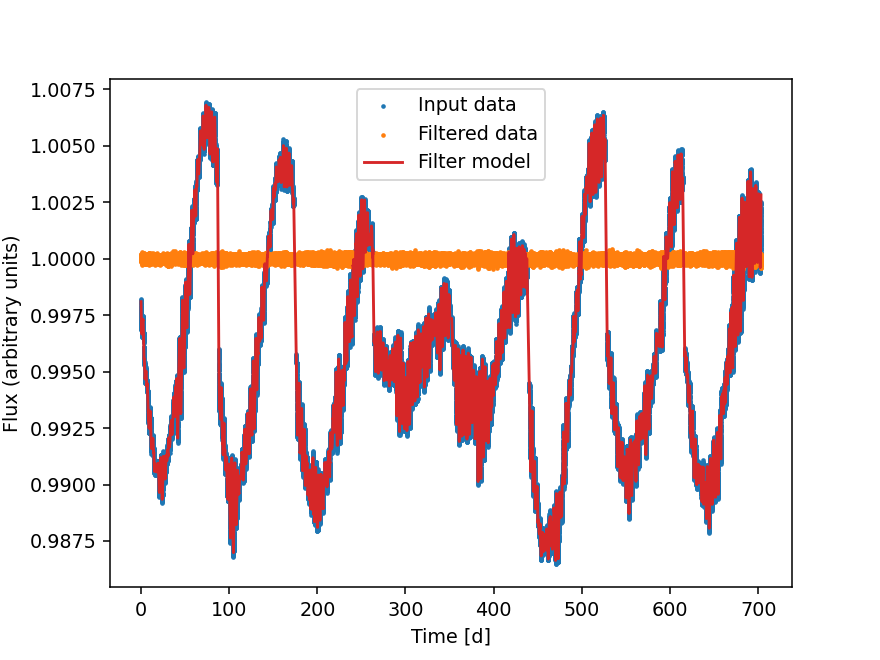

In [4]:
%matplotlib notebook


plt.scatter(time, flux, s=2, label = 'Input data')
plt.scatter(time, detrend, s=2, label='Filtered data')
plt.plot(time, polyshape, c='C3', label='Filter model')
plt.xlabel('Time [d]')
plt.ylabel('Flux (arbitrary units)')
plt.legend()
plt.show()


In [8]:
from transitleastsquares import transitleastsquares
flux_filtered = detrend/np.median(detrend)
model_tls = transitleastsquares(time, flux)
results = model_tls.power(period_min=18.00,period_max=25, n_transits_min=2, use_threads=18)
Porb= results.period
try:
    epoch= results.transit_times[0]
except:
    epoch=results.transit_times
depth= 1.- results.depth
duration= results.duration
errP= results.period_uncertainty
rp_rs= results.rp_rs
SDE=results.SDE
print(Porb, epoch )

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 31 durations
Searching 99136 data points, 3313 periods from 18.001 to 25.0 days
Using 18 of 12 CPU threads


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3313/3313 periods | 03:13<00:00


nan nan


In [9]:
from astropy.timeseries import BoxLeastSquares #for the BLS transit search
flux_filtered = detrend/np.median(detrend)

print('BLS transit search...')
model_bls = BoxLeastSquares(time, flux_filtered)
results = model_bls.autopower(0.1, minimum_period=18.0, maximum_period=25, minimum_n_transit=2,  objective="snr")
max_power = np.argmax(results.power)
Porb = results.period[max_power] #orbital period from BLS search
epoch = results.transit_time[max_power]
depth = (results.depth[max_power])
duration = results.duration[max_power]
snr=results.depth_snr[max_power]
print(Porb, epoch )

BLS transit search...
21.96650745382509 8.277845716666668


<IPython.core.display.Javascript object>


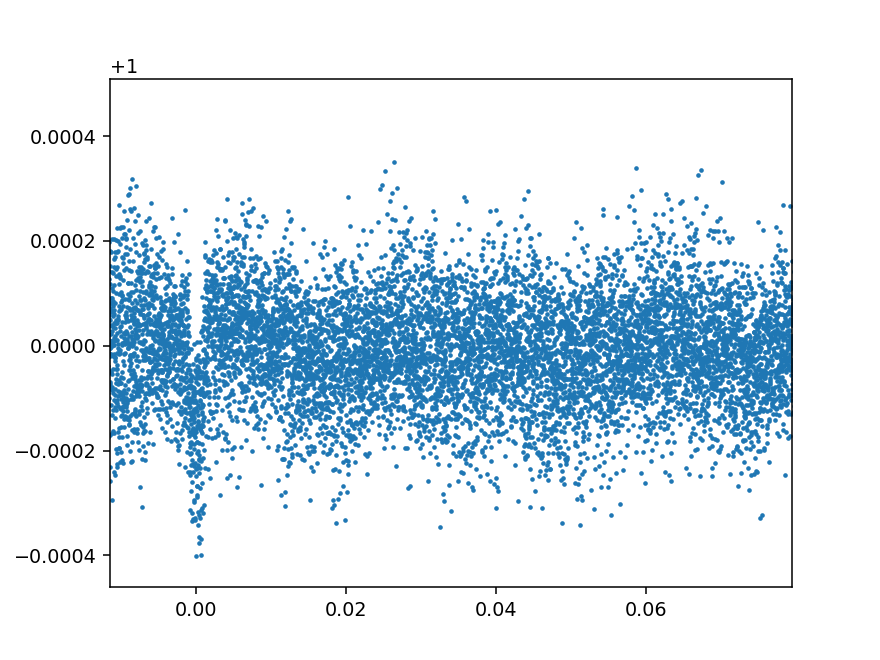

In [6]:
P = 21.967093019867807
Tc = 96.1580657
plt.figure()
phase = ((time - Tc + P/2) % P ) / P - 0.5 
plt.scatter(phase, detrend, s=2)
plt.show()